In [1]:
#import all packages
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import math
from tensorflow import keras
import random
from varname import varname

C:\Users\Arik\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Arik\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Arik\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Arik\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passing (

In [2]:
from keras.models import Sequential
from keras.layers import Conv1D, Conv2D, MaxPooling1D, Dense, Flatten, Dropout, GlobalAveragePooling1D, LSTM, Bidirectional

Using TensorFlow backend.


# Create Database
Create database of noisy polygonal lines and circles

In [3]:
def GenerateDB(NMag, linesNum, CircleNum, PointsOnLine, pointsOnCircle):
    lineEq = lambda a,b,x:  a*x + b #Equation of the line 
    noise = (0.5 - np.random.rand(PointsOnLine, linesNum)) * NMag #additive noise variable
    xLine = np.random.rand(PointsOnLine, linesNum) #randomize X coordinates of the lines
    a = np.random.rand(linesNum) #random slops
    b = np.random.rand(linesNum)
    a = np.tile(a,(PointsOnLine,1))
    b = np.tile(b,(PointsOnLine,1))
    yLine = lineEq(a,b,xLine) + noise #create the lines
    #create circles for database
    noiseX = (0.5 - np.random.rand(pointsOnCircle, CircleNum)) * NMag
    noiseY = (0.5 - np.random.rand(pointsOnCircle, CircleNum)) * NMag
    rad = np.random.rand(CircleNum)
    x0 = np.random.rand(CircleNum)
    y0 = np.random.rand(CircleNum)
    rad = np.tile(rad,(pointsOnCircle,1))#repeat(rad, pointsOnCircle, axis=1).reshape(pointsOnCircle, linesNum)
    x0 = np.tile(x0, (pointsOnCircle,1))#.reshape(pointsOnCircle, linesNum)
    y0 = np.tile(y0, (pointsOnCircle,1))#.reshape(pointsOnCircle, linesNum)
    CircleAngle = np.random.rand(pointsOnCircle, CircleNum) * np.pi * 2
    xC = np.cos(CircleAngle) * rad + x0 + noiseX
    yC = np.sin(CircleAngle) * rad + y0 + noiseY
    return xLine, yLine, xC, yC

In [4]:
def NormalizeAndConcatData(x,y):
    x0 = np.mean(x, axis=1)
    y0 = np.mean(y, axis=1)
    x = x - x0[:,None]
    y = y - y0[:,None]
    bXmin = np.min(x,axis=0)
    bYmin = np.min(y,axis=0)
    bXmax = np.max(x,axis=0)
    bYmax = np.max(y,axis=0)
    B = np.concatenate((bXmin,bYmin,bXmax,bYmax))
    B = np.std(B)
    x = x.T
    y = y.T
    mat = np.concatenate((x[:,:,None], y[:,:,None]), axis=2)
    mat /= B
    return mat

In [5]:
def SplitTestTrain(xLine, yLine, XCirc, yCirc, linesNum, CircleNum, TrainPart=0.6):
    #Sample Lines
    TrainLineNum = int(np.round(TrainPart * linesNum))
    ind = random.sample(range(linesNum), TrainLineNum)#np.random.randint(linesNum, size=TrainLineNum)
    line_train_x = xLine[:, ind]
    line_train_y = yLine[:, ind]
    print(len(ind), linesNum)
    TestInd = [i for i in range(linesNum) if i not in ind]
    print(len(TestInd))
    line_test_x = xLine[:, TestInd]
    line_test_y = yLine[:, TestInd]
    #Organize data
    LineMat = NormalizeAndConcatData(line_train_x, line_train_y)
    LineMatTest = NormalizeAndConcatData(line_test_x, line_test_y)

    #Sample circles
    TrainCircleNum = int(TrainPart * CircleNum)
    ind = random.sample(range(CircleNum), TrainCircleNum)#ind = np.random.randint(CircleNum, size=TrainCircleNum)
    TestInd = [i for i in range(CircleNum) if i not in ind]
    circle_train_x = XCirc[:, ind]
    circle_train_y = yCirc[:, ind]
    circle_test_x = XCirc[:, TestInd]
    circle_test_y = yCirc[:, TestInd]
    CircleMat = NormalizeAndConcatData(circle_train_x, circle_train_y)
    CircleMatTest = NormalizeAndConcatData(circle_test_x, circle_test_y)

    #Merge circles and lines
    TrainMat = np.concatenate((CircleMat,LineMat), axis=0)
    TestMat = np.concatenate((CircleMatTest,LineMatTest), axis=0)
    TrainClassVec = np.concatenate((np.zeros(TrainCircleNum),np.ones(TrainLineNum)))#0 - circle, 1 - line 
    ClassVecTest = np.concatenate((np.zeros(CircleNum-TrainCircleNum),np.ones(linesNum-TrainLineNum)))
    ind = np.arange(TrainLineNum+TrainCircleNum)
    #Shuffle the samples
    np.random.shuffle(ind)
    TrainMat = TrainMat[ind,:,:]
    TrainClassVec = TrainClassVec[ind]
    return TrainMat, TestMat, TrainClassVec, ClassVecTest

 # Model Construction - Convolutional

In [6]:
def CreateModel(FliterNum, KSize, MaxPoolK, PoolStride, ClassNum, input_shape):
    #Create layers
    model = Sequential()
    model.add(Conv1D(filters=FliterNum, kernel_size=KSize, activation='relu', input_shape=input_shape, padding='same'))
    model.add(MaxPooling1D(pool_size=MaxPoolK,strides=PoolStride,data_format='channels_last'))
    model.add(Conv1D(filters=2*FliterNum, kernel_size=KSize, activation='relu'))
    model.add(GlobalAveragePooling1D(data_format='channels_last'))
    model.add(Dense(FliterNum, activation='relu'))
    if ClassNum>2:
        model.add(Dense(ClassNum, activation='softmax'))
    else:
        model.add(Dense(1, activation='sigmoid'))
    return model

# Model Construction - LSTM

In [7]:
def CreateLSTM(FilterNum=64, drop=0):
    model = Sequential()
    model.add(Bidirectional(LSTM(FilterNum)))
    if drop != 0:
        model.add(Dropout(drop))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Run Model - Convolutional

In [8]:
def FitAndEvaluate(model, TrainMat, TrainClassVec, TestMat, ClassVecTest, EpochNum, BatchSize, metrics=['accuracy'], verbose=0):
    #Compile model
    if ClassNum>2:
        model.compile(
            loss='categorical_crossentropy', 
            optimizer='adam', 
            metrics=metrics
        )
    else:
        model.compile(
            loss='binary_crossentropy', 
            optimizer='rmsprop', 
            metrics=metrics
        )
    # Train the model, iterating on the data in batches of 32 samples
    his = model.fit(TrainMat, TrainClassVec, epochs=EpochNum, batch_size=BatchSize, verbose=verbose)
    #evaluate model for test set
    score = model.evaluate(TestMat, ClassVecTest, batch_size=BatchSize, verbose=verbose)
    return score, his

# Run Model - LSTM

In [9]:
def RunLSTM(model, x_train, y_train, x_test, y_test, EpochNum, BatchSize, metrics=['accuracy'], verbose=0):
    model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
    
    his = model.fit(x_train, y_train,
              batch_size=BatchSize,
              epochs=EpochNum,
              validation_data=[x_test, y_test])
    score = model.evaluate(x_test, y_test, batch_size=BatchSize, verbose=verbose)
    
    return score, his

# Plot Sample Data

In [10]:
 def PlotSamples(xCirc, yCirc, xLine, yLine, noise):
    #plot samples
    plt.figure()
    plt.plot(xCirc[:,0:3], yCirc[:,0:3],'.')
    plt.title('circles, noise='+str(noise))

    plt.figure()
    plt.plot(xLine[:,0:3], yLine[:,0:3],'.')
    plt.title('lines, noise='+str(noise))
    
    plt.show(block=True)

# Evaluate & display

In [11]:
def RunModel(model, EpochNum, BatchSize, metrics=['accuracy'], isPlot = True, isPrint = False, mode='conv'):   
    loss = np.zeros((len(EpochNum),len(BatchSize)))
    acc = np.zeros((len(EpochNum),len(BatchSize)))
    accTrain = np.zeros((len(EpochNum),len(BatchSize)))
    lossTrain = np.zeros((len(EpochNum),len(BatchSize)))
    for i, eNum in enumerate(EpochNum):
        for j, bs in enumerate(BatchSize):
            if mode=='conv':
                score, hist = FitAndEvaluate(model, TrainMat, TrainClassVec, TestMat, ClassVecTest, eNum, bs, metrics=metrics)
            elif mode=='lstm':
                score, hist = RunLSTM(model, TrainMat, TrainClassVec, TestMat, ClassVecTest, eNum, bs, metrics=metrics)
            else:
                print(mode + ": no such model")
                return
            accTrain[i, j] = hist.history['accuracy'][-1]
            lossTrain[i, j] = hist.history['loss'][-1]
            loss[i, j] = score[0]
            acc[i, j] = score[1]
            if isPrint:
                print ("batch="+str(bs)+",epoch="+str(eNum))

    if isPlot:
        fig, ax = plt.subplots(1,1)
        ax.plot(EpochNum, loss)
        ax.legend(BatchSize)
        ax.set_title('Test Loss')

        fig, ax2 = plt.subplots(1,1)
        ax2.plot(EpochNum, acc)
        ax2.legend(BatchSize)
        ax2.set_title('Test Accuracy')

        fig, ax3 = plt.subplots(1,1)
        ax3.plot(EpochNum, accTrain-acc)
        ax3.legend(BatchSize)
        ax3.set_title('Test-Train Gap')
    
    return loss, acc, accTrain-acc

In [12]:
def SaveToFile(FN, varList=[]):
    with open(FN, 'w') as f:
        for var in varList:
            if len(var)>1:
                f.write("%s\n" % varname(var))
            for item in var:
                f.write("%s\n" % item)

# Define Model & Data Variables

In [15]:
#Create line for database
NMag = [1,5,10]#Noise magnitude
linesNum = 50 #number of lines for the database
PointsOnLine = 15 #number of points on each line
TrainPart = 0.4
CircleNum = 60
ClassNum = 2
EpochNum = [4,6,8]#range(2,11,1)
BatchSize = [1,2,4]#[4,8,16,32]
pointsOnCircle = PointsOnLine
FliterNum = 32
KSize = 5
MaxPoolK = 3
PoolStride = 3
AllLoss = []
AllAcc = []
AllGap = []
mode = 'conv'

# Generate and Organize Data

noise=1
20 50
30
noise=5
20 50
30
noise=10
20 50
30


ValueError: Expected 1D or 2D array, got 4D array instead

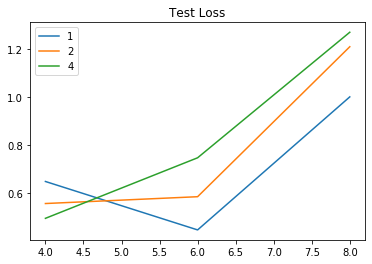

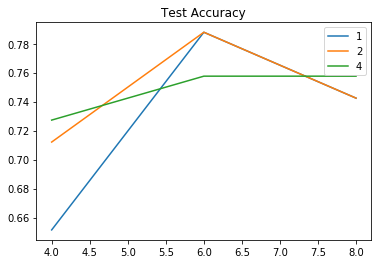

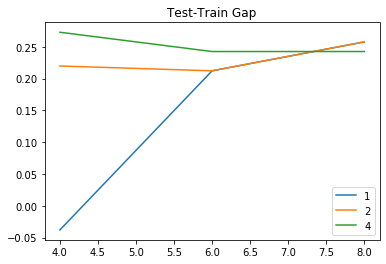

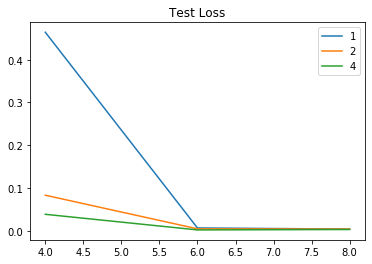

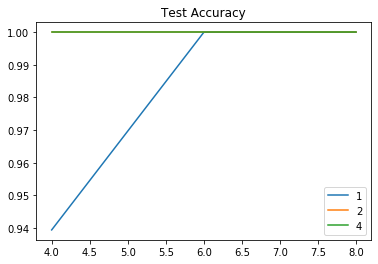

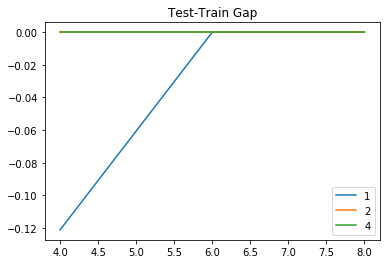

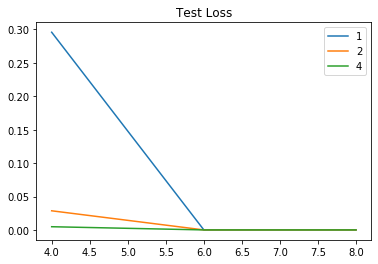

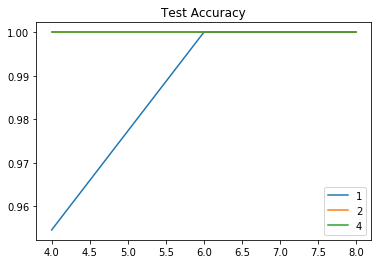

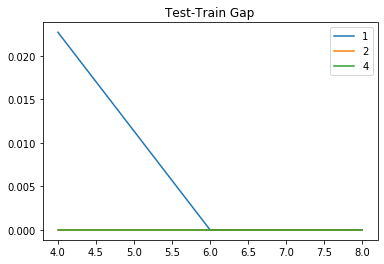

In [16]:
for noise in NMag:
    print("noise="+str(noise))
    xLine, yLine, xCirc, yCirc = GenerateDB(noise, linesNum, CircleNum, PointsOnLine, pointsOnCircle)#GenerateDB(NMag, linesNum, CircleNum)
    #PlotSamples(xCirc, yCirc, xLine, yLine, noise)
    TrainMat, TestMat, TrainClassVec, ClassVecTest = SplitTestTrain(xLine, yLine, xCirc, yCirc, linesNum, CircleNum, TrainPart)
    input_shape = TrainMat.shape[1:]# + (1,)
    if mode=='conv':
        model = CreateModel(FliterNum, KSize, MaxPoolK, PoolStride, ClassNum, input_shape)
    else:
        model = CreateLSTM(FilterNum=64, drop=0)
    loss, acc, gap = RunModel(model, EpochNum, BatchSize, metrics=['accuracy'], mode=mode)
    AllLoss.append(loss)
    AllAcc.append(acc)
    AllGap.append(gap)
np.savetxt(mode+'_loss.txt',[AllLoss])
np.savetxt(mode+'_acc.txt',[AllAcc])
np.savetxt(mode+'_gap.txt',[AllGap])
SaveToFile(mode+'_noise.txt', [NMag, BatchSize, EpochNum])